In [ ]:
load('/nfs/mqc/Consensus_peak/code/validataion/data6_10x/bulkPeaks.clustering.image')


In [3]:
suppressPackageStartupMessages({
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v75)
    library(ggplot2)
    library(patchwork)
    set.seed(1234)
    library(qs)
    library(tidyverse)
})

In [7]:
pbmc <- readRDS('data/bulk.seuratObject.rds')

In [14]:
pbmc <- RunTFIDF(pbmc)
pbmc <- FindTopFeatures(pbmc, min.cutoff = 'q0')
pbmc <- RunSVD(pbmc)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



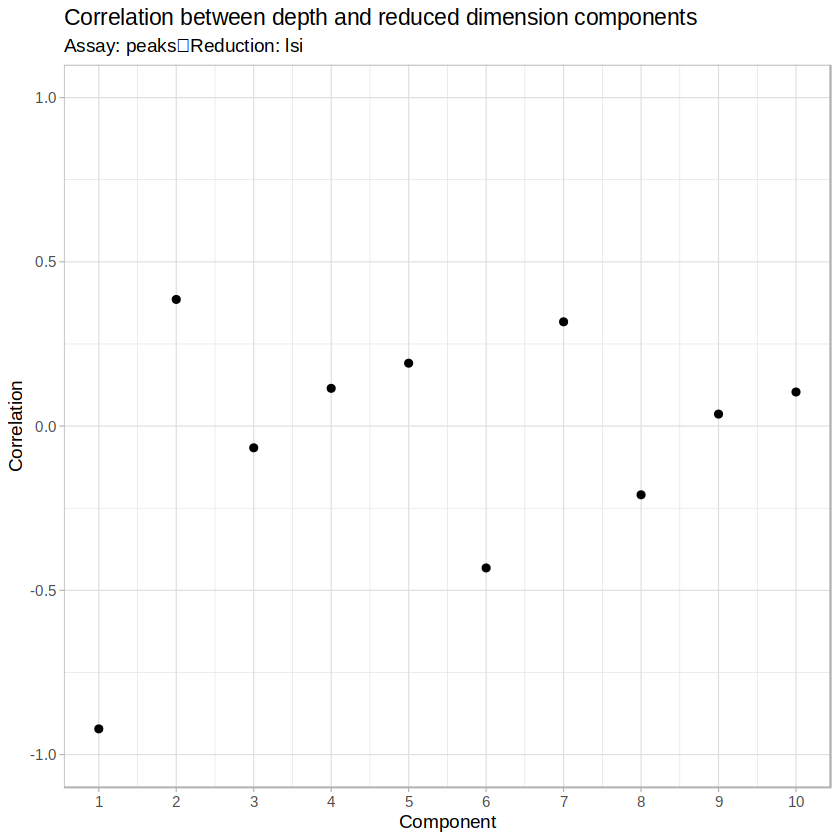

In [6]:
DepthCor(pbmc)

In [ ]:
pbmc <- RunUMAP(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindNeighbors(object = pbmc, reduction = 'lsi', dims = 2:30)
pbmc <- FindClusters(object = pbmc, verbose = FALSE, algorithm = 3)


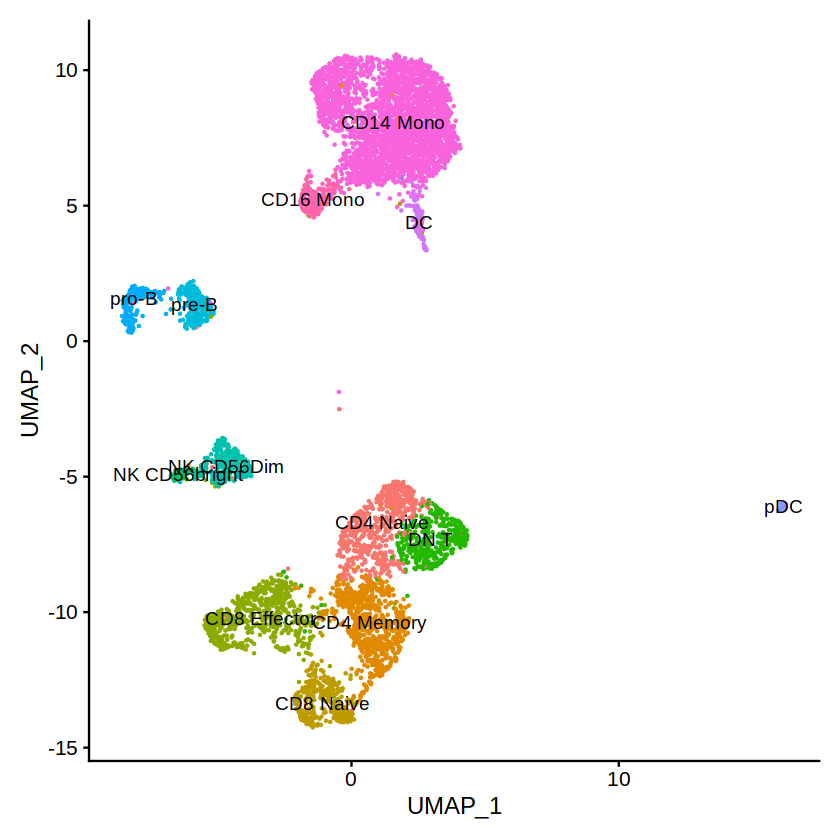

In [8]:
DimPlot(object = pbmc, label = TRUE) + NoLegend()

In [17]:
# gene.activities <- GeneActivity(pbmc)

# # add the gene activity matrix to the Seurat object as a new assay and normalize it
# pbmc[['RNA']] <- CreateAssayObject(counts = gene.activities)
# pbmc <- NormalizeData(
#   object = pbmc,
#   assay = 'RNA',
#   normalization.method = 'LogNormalize',
#   scale.factor = median(pbmc$nCount_RNA)
# )

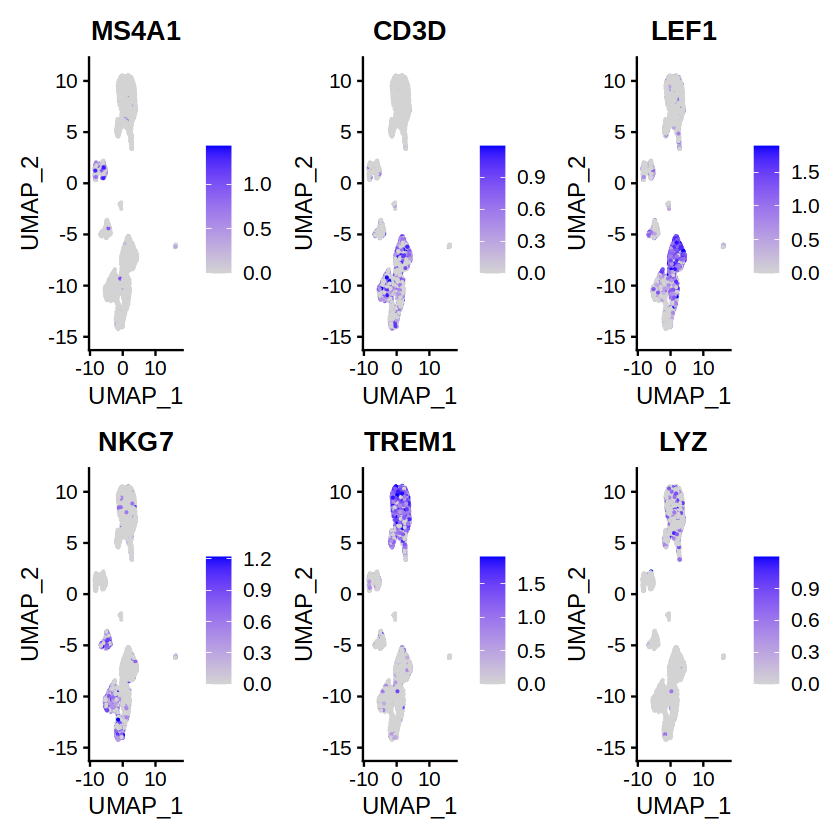

In [19]:
DefaultAssay(pbmc) <- 'RNA'

FeaturePlot(
  object = pbmc,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

In [20]:
# Load the pre-processed scRNA-seq data for PBMCs
pbmc_rna <- readRDS("./data/rna.seuratObject.rds")

transfer.anchors <- FindTransferAnchors(
  reference = pbmc_rna,
  query = pbmc,
  reduction = 'cca'
)

predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = pbmc_rna$celltype,
  weight.reduction = pbmc[['lsi']],
  dims = 2:30
)

pbmc <- AddMetaData(object = pbmc, metadata = predicted.labels)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17306 anchors

Filtering anchors

	Retained 4019 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



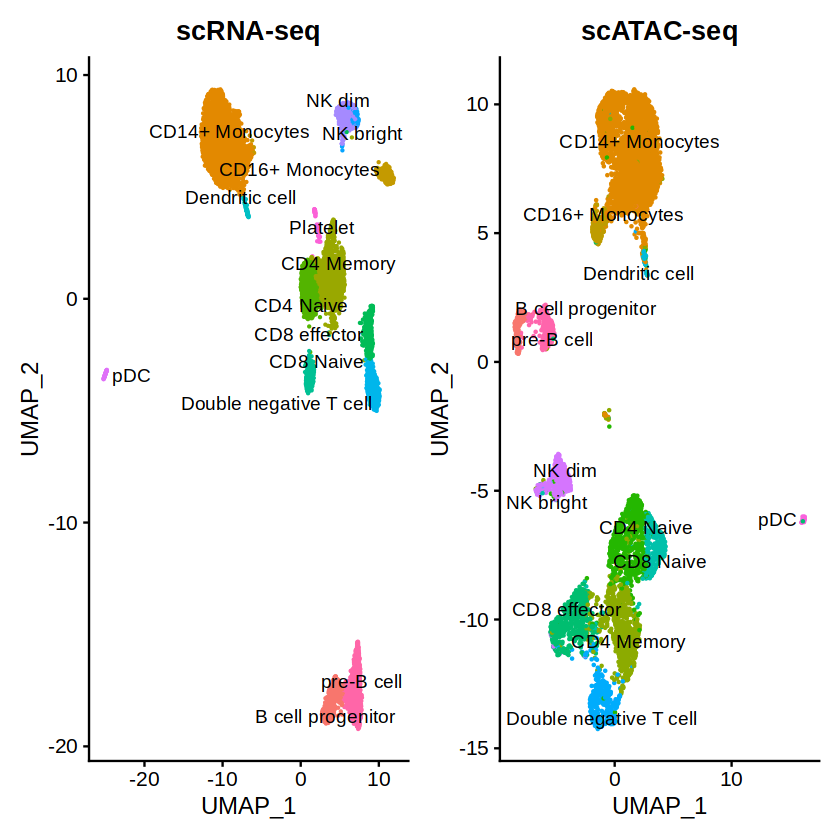

In [21]:
plot1 <- DimPlot(
  object = pbmc_rna,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = pbmc,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

plot1 + plot2

In [24]:
# change back to working with peaks instead of gene activities
DefaultAssay(pbmc) <- 'peaks'

In [ ]:
df.pdc <- pbmc@meta.data%>%dplyr::filter(predicted.id=='pDC')#%>%table

# change back to working with peaks instead of gene activities
DefaultAssay(pbmc) <- 'peaks'

da_peaks.pdc <- FindMarkers(
  object = pbmc,
  ident.1 = "pDC",
  #ident.2 = "CD14 Mono",
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)